Notebook to calculate correlation and mutual information between starting features and the target SalePrice

**Imports**

In [1]:

import os


import pandas as pd

import sklearn as sk
import sklearn.feature_selection
import sklearn.pipeline

import pyplotterlib.standard.plotters as ppl

#Specific to this repository
import project_path
import preproc_pipes as preProcPipeHelp
import train_pipes as trainPipeHelp


**Configuration Variables**

In [2]:
#
TRAIN_PATH = os.path.abspath( os.path.join("..","..","raw_data","train.csv")  )

#
_currKwargs = {"constrainedLayout":True, "figHeightPerRow":3, "figWidthPerCol":4, "nColsGrid":2}
RECT_PLOTTER = ppl.RectMultiPlotter(**_currKwargs)

**Import the data**

In [3]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)

**Do some basic pre-processing/data cleaning**

In [4]:
_ordEncoder = preProcPipeHelp.OrdinalEncoder( preProcPipeHelp.getStandardOrdinalEncodeKeys() )

_pipeComps = [ 
               ("Replace text values with basic ordinal encoding", _ordEncoder),
               ("Factorise any remaining categorical groups", preProcPipeHelp.FactorizeRemainingCateGroups() ),
               ("Impute NaN values for numerical fields", trainPipeHelp.TransformNumericalNaN()),
             ]


PROC_PIPE = sk.pipeline.Pipeline(_pipeComps)

In [5]:
PROC_TRAIN = PROC_PIPE.fit_transform(RAW_TRAIN)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Get correlation of each feature to the target**

In [6]:
pearCorrs = PROC_TRAIN.corr()["SalePrice"].to_dict()
pearCorrs.pop("SalePrice")

#Want [label,correlation] in order of correlation; will be useful for plotting
_sortedPairs = sorted( [[label,value] for label,value in pearCorrs.items()], key=lambda x:abs(x[1]), reverse=True  )
pearCorrLabels = [ x[0] for x in  _sortedPairs ]
pearAbsCorrValues = [ abs(x[1]) for x in _sortedPairs  ]

**Get mutual information of each feature to the target**

In [7]:
def _getMutualInfoVals(inpFrame, targCol="SalePrice"):
    #
    targCol = "SalePrice"
    useX = PROC_TRAIN.copy()
    useX = useX.drop("Id",axis=1) #Doesnt work unless id is dropped
    useY = useX.pop(targCol)

    #
    discFeatNames = preProcPipeHelp.getDiscreteFeatureNames()
    columns = useX.columns
    discreteFeatsMask = [1 if x in discFeatNames else 0 for x in columns]
    
    #
    _currKwargs = {"discrete_features":discreteFeatsMask, "random_state":0}
    miScores = sk.feature_selection.mutual_info_regression(useX.to_numpy(), useY.to_numpy(), **_currKwargs)
    colNames = useX.columns
    _sortedPairs = sorted( [ [col,mi] for col,mi in zip(colNames,miScores) ], key=lambda x:x[1], reverse=True)

    colNames = [x[0] for x in _sortedPairs]
    miVals = [x[1] for x in _sortedPairs]
    
    return colNames,miVals


In [8]:
miLabels, miVals = _getMutualInfoVals(PROC_TRAIN)

**Plot which features have the top correlation/mutual information values**

In [9]:
#
_showN = 20
_currKwargs = {"plotHorizontally":True, "gridLinesShowX":True, "fontSizeDefault":10}
templBarPlotter = ppl.BarPlotter(**_currKwargs)

#Plotter for correlation
_currKwargs = {"plotData1D":[ list(reversed(pearAbsCorrValues[:_showN])) ],
               "groupLabels":  list(reversed( pearCorrLabels[:_showN] )),
               "titleStr": "Features with best correlation to price","xLabelStr":"Absolute Correlation"}
corrBarPlotter = templBarPlotter.createFactory(**_currKwargs)

#Plotter for mutual information
_currKwargs = {"plotData1D":[ list(reversed(miVals[:_showN])) ],
               "groupLabels":  list(reversed( miLabels[:_showN] )),
               "titleStr": "Features with Highest MI to price","xLabelStr":"Mutual Information"}
miBarPlotter = templBarPlotter.createFactory(**_currKwargs)


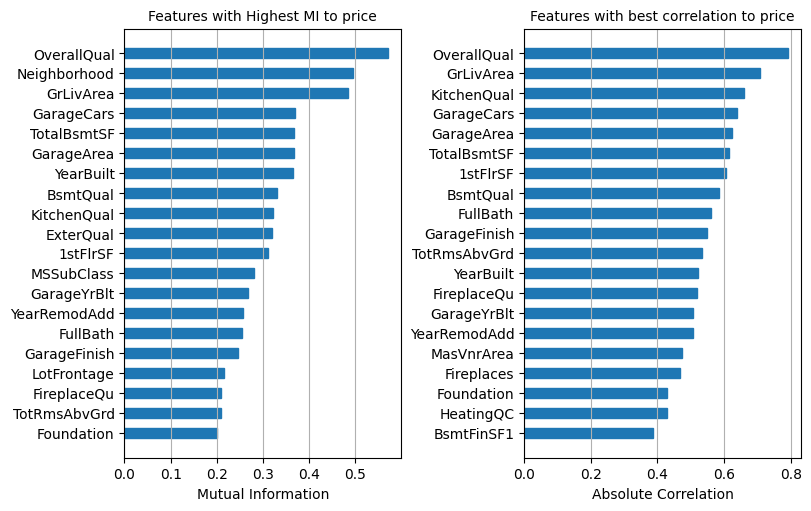

In [13]:
_unused = RECT_PLOTTER.createPlot(plotters=[miBarPlotter, corrBarPlotter], figHeightPerRow=5)

**Create scatter plots for features with high MI with sale price**

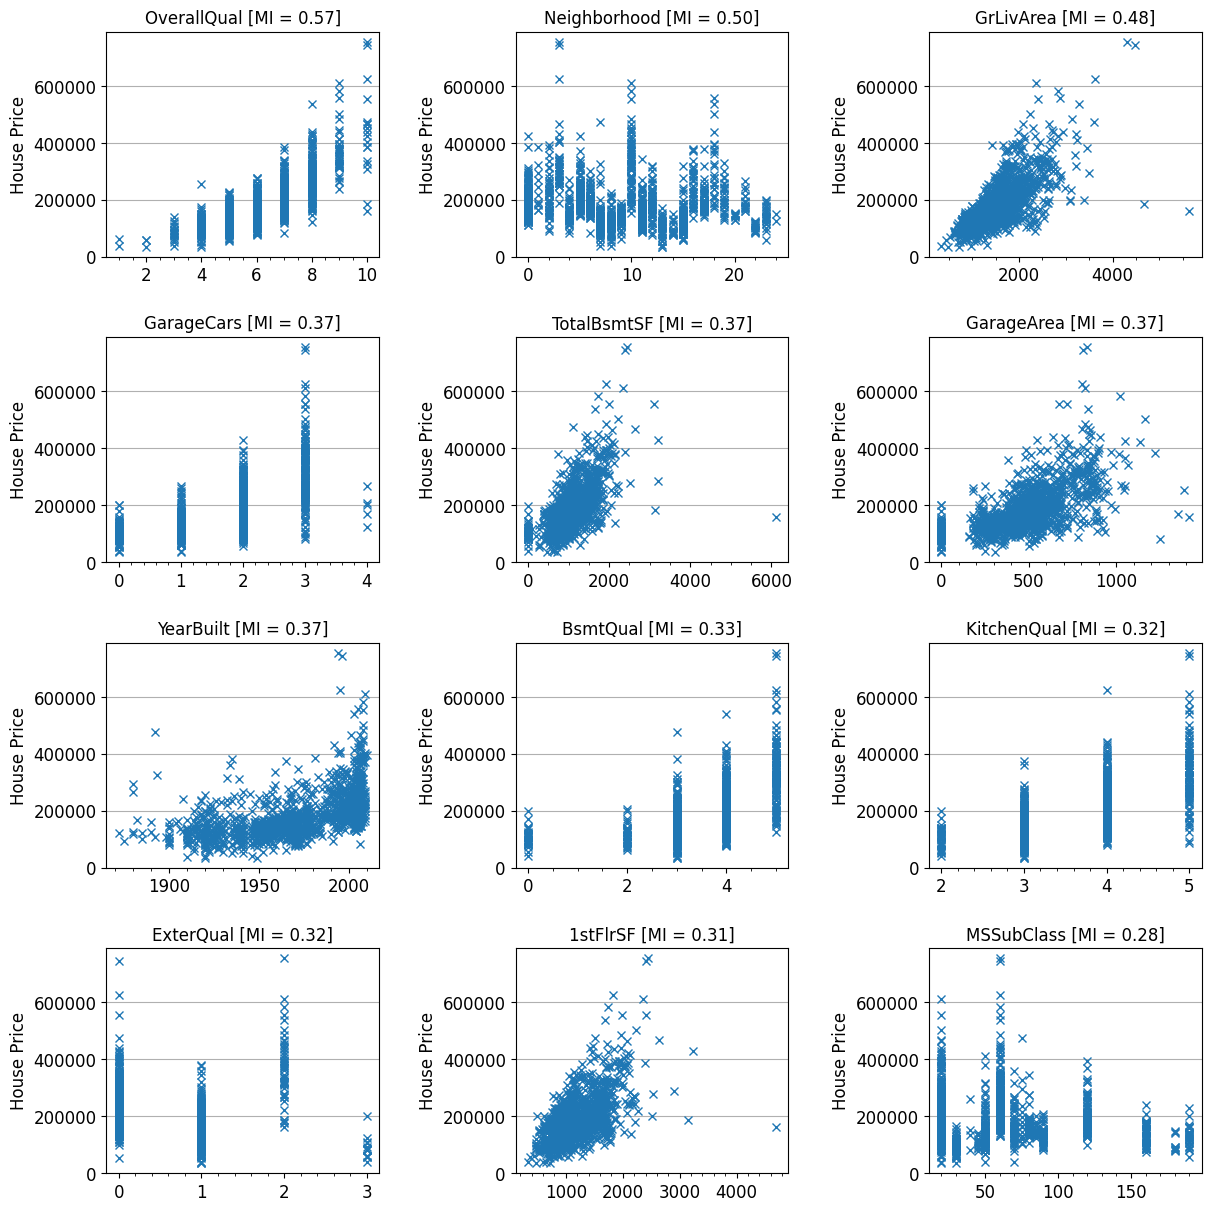

In [11]:
_currKwargs = {"fontSizeDefault":12, "gridLinesShowY":True, "lineMarkerStyles":["x"],
               "lineStyles":["None"], "showMinorTickMarkersX":True,
               "yLabelStr":"House Price"}
templLinePlotter = ppl.LinePlotter(**_currKwargs)

#
plotN = 12
usePlotters = list()
for idx,xFeat in enumerate(miLabels[:plotN]):
    currData = [ PROC_TRAIN[[xFeat,"SalePrice"]].to_numpy() ]
    _title = xFeat + " [MI = {:.2f}]".format( miVals[idx] )
    currPlotter = templLinePlotter.createFactory(plotData=currData, titleStr=_title)
    usePlotters.append(currPlotter)

_unused = RECT_PLOTTER.createPlot(plotters=usePlotters, nColsGrid=3, spacingHoz=0.1, spacingVert=0.1)


**Two houses with large Ground living areas sold for very little; look at them more closely**

Useful to get their ids to remove from training later (due to them being outliers)

In [12]:
pd.set_option("display.max_columns",90)
RAW_TRAIN.loc[ (RAW_TRAIN["GrLivArea"]>4000) & (RAW_TRAIN["SalePrice"]<200000) ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
